# MRI VISUALIZATION from OASIS-3
### Jack Le - Polygence

In [1]:
import nibabel as nib
import ipywidgets as widgets
from scipy import ndimage
import os, random
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython import display as dspl

df = pd.read_csv('OASIS/oasis_3.csv')
df.head()

,Subject,MR ID,id,Age,M/F,dx1,mmse,cdr,apoe,TOTAL_HIPPOCAMPUS_VOLUME,...,rhCortexVol,CortexVol,SubCortGrayVol,TotalGrayVol,SupraTentorialVol,lhCorticalWhiteMatterVol,rhCorticalWhiteMatterVol,CorticalWhiteMatterVol,L.SurfArea,R.SurfArea
0,OAS30001,OAS30001_MR_d3132,OAS30001_Freesurfer53_d3132,73.0,F,Cognitively normal,30.0,0.0,23.0,6861.9,...,178031.558882,359975.257636,48400.0,491102.257636,7.736716e+05,174372.329393,173244.012238,347616.341631,67598.1,67185.8
1,OAS30001,OAS30001_MR_d0129,OAS30001_Freesurfer53_d0129,65.0,F,Cognitively normal,30.0,0.0,23.0,7678.9,...,187528.786036,379446.180091,50687.0,517683.180091,8.105851e+05,184600.488060,182662.445419,367262.933479,70168.1,69483.8
2,OAS30001,OAS30001_MR_d2430,OAS30001_Freesurfer53_d2430,71.0,F,Cognitively normal,30.0,0.0,23.0,7105.9,...,178872.680224,357784.489639,49058.0,487405.489639,7.779313e+05,175955.968883,178172.812666,354128.781549,67905.7,68000.2
3,OAS30001,OAS30001_MR_d0757,OAS30001_Freesurfer53_d0757,67.0,F,Cognitively normal,29.0,0.0,23.0,7648.2,...,177566.874682,362040.150904,50071.0,500699.150904,7.993419e+05,185224.779932,188151.990316,373376.770247,69142.3,68558.8
4,OAS30002,OAS30002_MR_d2345,OAS30002_Freesurfer53_d2345,73.0,M,Cognitively normal,29.0,0.0,34.0,7833.2,...,230240.532783,457342.035802,56773.0,607473.035802,1.051714e+06,239168.338419,245361.377267,484529.715686,83138.1,85742.3


## Data Cleaning

In [2]:
df = df.dropna(axis=1, how='all') # Drop any empty columns
df = df.dropna(axis=0, how='any') # Drop any rows with empty values
df = df.rename(columns={'id':'Freesurfer ID', 'dx1':'Diagnosis', # Rename columns
                        'TOTAL_HIPPOCAMPUS_VOLUME':'TotalHippocampusVol'})
df = df.sort_values(by=['Subject', 'Age']) # Sort the columns by subject, then age
df = df.drop_duplicates(subset='Subject', keep='first') # Keep only the first visit; this is possible because
                                                        # df is sorted by age
df = df.reset_index(drop=True) # Reset the index

In [3]:
def label_disease (row):
    if row['cdr'] < 0.5:
        return 0
    elif row['Diagnosis'] == 'Cognitively normal':
        return 0
    else:
        return 1
# Labels the diagnosis numerically
df.insert(6, 'Demented', df.apply (lambda row : label_disease(row), axis=1))
df.head()

,Subject,MR ID,Freesurfer ID,Age,M/F,Diagnosis,Demented,mmse,cdr,apoe,...,rhCortexVol,CortexVol,SubCortGrayVol,TotalGrayVol,SupraTentorialVol,lhCorticalWhiteMatterVol,rhCorticalWhiteMatterVol,CorticalWhiteMatterVol,L.SurfArea,R.SurfArea
0,OAS30001,OAS30001_MR_d0129,OAS30001_Freesurfer53_d0129,65.0,F,Cognitively normal,0,30.0,0.0,23.0,...,187528.786036,379446.180091,50687.000000,517683.180091,8.105851e+05,184600.488060,182662.445419,367262.933479,70168.1,69483.8
1,OAS30002,OAS30002_MR_d0653,OAS30002_Freesurfer53_d0653,68.0,M,Cognitively normal,0,30.0,0.0,34.0,...,236894.539679,471180.950626,60386.000000,628934.950626,1.085865e+06,253411.175744,257796.379281,511207.555026,85010.3,87126.4
2,OAS30003,OAS30003_MR_d0558,OAS30003_Freesurfer53_d0558,60.0,F,Cognitively normal,0,30.0,0.0,33.0,...,214696.395609,421337.406916,59540.000000,569622.406916,9.538035e+05,226794.049522,229032.005946,455826.055467,77748.9,80033.3
3,OAS30004,OAS30004_MR_d1101,OAS30004_Freesurfer53_d1101,58.0,F,Cognitively normal,0,30.0,0.0,23.0,...,216737.873611,436061.628148,54136.000000,585563.628148,9.794057e+05,238398.089623,234433.968088,472832.057710,86003.6,84289.7
4,OAS30005,OAS30005_MR_d0143,OAS30005_Freesurfer51_d0143,48.0,F,Cognitively normal,0,29.0,0.0,33.0,...,234532.952497,472022.810547,198617.449249,670640.259796,1.019123e+06,255716.750000,253689.734375,509406.484375,82802.7,81709.2


In [4]:
# Creates a sample from df, with equal distribution of CN and Demented
samp_df = df.groupby('Demented').apply(lambda x: x.sample(n=10, random_state=1)).reset_index(drop = True)
samp_df.head()

,Subject,MR ID,Freesurfer ID,Age,M/F,Diagnosis,Demented,mmse,cdr,apoe,...,rhCortexVol,CortexVol,SubCortGrayVol,TotalGrayVol,SupraTentorialVol,lhCorticalWhiteMatterVol,rhCorticalWhiteMatterVol,CorticalWhiteMatterVol,L.SurfArea,R.SurfArea
0,OAS30319,OAS30319_MR_d0043,OAS30319_Freesurfer53_d0043,52.0,F,Cognitively normal,0,28.0,0.0,33.0,...,215463.137759,432202.575736,59682.0,600447.575736,9.684294e+05,231420.662820,227742.160614,459162.823434,79301.4,78742.4
1,OAS30187,OAS30187_MR_d0070,OAS30187_Freesurfer53_d0070,69.0,M,Cognitively normal,0,30.0,0.0,22.0,...,206481.344712,409048.927762,49082.0,540514.927762,9.156372e+05,212237.003726,213698.315772,425935.319498,80261.6,80440.1
2,OAS30707,OAS30707_MR_d0453,OAS30707_Freesurfer53_d0453,84.0,M,Cognitively normal,0,29.0,0.0,34.0,...,209777.844623,417006.254842,53288.0,557491.254842,9.979297e+05,212839.014461,218128.475910,430967.490370,87176.2,86303.2
3,OAS30713,OAS30713_MR_d0095,OAS30713_Freesurfer53_d0095,70.0,M,Cognitively normal,0,30.0,0.0,33.0,...,241160.461674,481131.578644,60019.0,632272.578644,1.118171e+06,273108.315782,273504.602185,546612.917967,92350.2,92192.2
4,OAS31107,OAS31107_MR_d0912,OAS31107_Freesurfer53_d0912,69.0,F,Cognitively normal,0,30.0,0.0,33.0,...,242831.843654,487340.610810,55289.0,658025.610810,1.082691e+06,251933.107555,248947.377523,500880.485078,85370.6,85872.0


In [5]:
# creates the list of wanted MRI's to download from database
mri_ids = samp_df['MR ID']
# the next line is commented out to prevent the mri_ids csv from getting messed up
## mri_ids.to_csv('OASIS/mri_id.csv')

## MRI Visualizations

In [6]:
# chooses a random MRI based on the chosen patient type
scan_dir, patient_data, image_data = None, None, None
def choose_image(type):
    global scan_dir, patient_data, image_data
    # Chooses a random image from the chosen group
    dir = "OASIS/MRI_DATA/DEM" if type == 'Demented' else "OASIS/MRI_DATA/CN"
    id_path = random.choice(os.listdir(dir))
    mri_dir = os.path.join(dir, id_path)
    mri_path = random.choice(os.listdir(mri_dir))
    img_dir = os.path.join(mri_dir, mri_path)
    img_path = [file for file in os.listdir(img_dir) if file.endswith('.gz')]
    scan_dir = os.path.join(img_dir, img_path[0])
    # print(f'Path of current MRI: {scan_dir}')

    # Loads image
    image_obj = nib.load(scan_dir)
    image_data = image_obj.get_fdata()

    # Sets up data table at bottom
    patient_data = samp_df.loc[samp_df['MR ID'] == id_path].drop(df.columns.difference(['Age', 'MR ID', 'M/F', 'mmse', 'apoe', 
    'TotalHippocampusVol', 'IntraCranialVol', 'TotalGrayVol']), 1)

# Assigns current variables
choose_image("Cognitively Normal")
height, width, depth = image_data.shape

In [7]:
# graphs the MRI image
def show_graph(img, height, width, depth, color, pat_type, rot):
    # Plots brain scans in all three dimensions
    fig = plt.figure(figsize=(15,7))
    gs = gridspec.GridSpec(nrows=3, ncols=3)

    ax0 = fig.add_subplot(gs[0:2,0])
    ax1 = fig.add_subplot(gs[0:2,1])
    ax2 = fig.add_subplot(gs[0:2,2])

    ax0.set_title("View 1")
    ax0.axis('off')
    ax1.set_title("View 2")
    ax1.axis('off')
    ax2.set_title("View 3")
    ax2.axis('off')

    colormap = 'gray' if color == 'Gray' else 'viridis'
    ax0.imshow(ndimage.rotate(img[height, :, :],rot[0]), cmap=colormap)
    ax1.imshow(ndimage.rotate(img[:, width, :],rot[1]), cmap=colormap)
    ax2.imshow(ndimage.rotate(img[:, :, depth],rot[2]), cmap=colormap)

    # Bottom data table
    bbox=[0, 0, 1, 1]
    fig.suptitle(f'3D T1w Brain Scans for {pat_type} Patient')
    data = fig.add_subplot(gs[2,:])
    data.axis('off')
    tbl = data.table(cellText=patient_data.values, bbox=bbox, colLabels=patient_data.columns)
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    fig.tight_layout()

In [8]:
# displays the MRI in an interactive manner
# note: this may not show correctly, so look at the animations
#       below to see the brain scans

co = widgets.ToggleButtons(options=['Gray', 'Color'])
st = widgets.ToggleButtons(options=['Cognitively Normal', 'Demented'])

def changed(change):
    global height, width, depth
    choose_image(change['new'])
    height, width, depth = image_data.shape
    dspl.clear_output()
    disp()
st.observe(changed, 'value')


def disp():
    print(f'Path of current MRI: {scan_dir}')
    hi = widgets.IntSlider(value=height/2, max=height-1, continous_updates=False, description='View 1')
    wi = widgets.IntSlider(value=width/2, max=width-1, continous_updates=False, description='View 2')
    de = widgets.IntSlider(value=depth/2, max=depth-1, continous_updates=False, description='View 3')
    top_box = widgets.HBox([hi, wi, de])
    bot_box = widgets.HBox([widgets.Label("Color Map"), co,
                            widgets.Label("Patient Type"), st])
    ui = widgets.VBox([top_box, bot_box])
    
    rot_mat = [90, 90, 90] if height < width else [180, 0, 90]
    display_output = widgets.interactive_output(show_graph, {'img':widgets.fixed(image_data),
                                                             'height':hi,
                                                             'width':wi,
                                                             'depth':de,
                                                             'color':co,
                                                             'pat_type':st, 
                                                             'rot':widgets.fixed(rot_mat)})
    dspl.display(ui, display_output)

disp()

Path of current MRI: OASIS/MRI_DATA/CN/OAS30822_MR_d0036/anat3/sub-OAS30822_ses-d0036_run-02_T1w.nii.gz


Output()

In [9]:
from matplotlib import animation, rc

In [10]:
rc('animation', html='html5')

In [11]:
choose_image("Cognitively Normal")
print(image_data.shape)
height, width, depth = image_data.shape

(176, 256, 256)


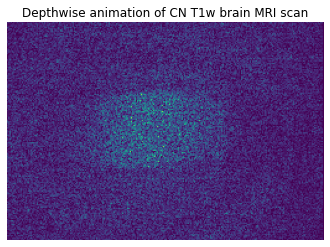

In [17]:
fig = plt.figure()
plt.axis('off')
plt.title('Depthwise animation of CN T1w brain MRI scan')
images = []

for i in range(depth-1):
    im = plt.imshow(image_data[:, :, i], animated=True)
    images.append([im])
ani = animation.ArtistAnimation(fig, images, interval=50, blit=True, repeat_delay=1000)
dspl.HTML(ani.to_html5_video())

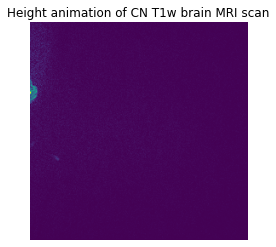

In [13]:
fig = plt.figure()
plt.axis('off')
plt.title('Height animation of CN T1w brain MRI scan')
images = []
for i in range(height-1):
    im = plt.imshow(image_data[i, :, :], animated=True)
    images.append([im])
ani = animation.ArtistAnimation(fig, images, interval=50, blit=True, repeat_delay=1000)
dspl.HTML(ani.to_html5_video())